# Bordas e Linhas

## Descrição

Este conjunto de problemas é o seu primeiro projeto de “visão” onde você calcula uma “resposta” - que é alguma descrição estrutural ou semântica do que está em uma imagem. Você encontrará bordas e objetos. Você aprenderá que alguns métodos funcionam bem para situações cuidadosamente controladas e quase não funcionam quando você relaxa essas restrições.

**REGRAS**: Você pode usar funções prontas de processamento de imagem para encontrar bordas, como Canny ou outros operadores. Não se esqueça de que eles têm uma variedade de parâmetros e você pode precisar experimentá-los. No entanto,  VOCÊ NÃO PODE USAR NENHUMA FERRAMENTA DE HOUGH. Por exemplo, você precisa escrever suas próprias estruturas de dados de matriz de acumulador e código para votação e localização de pico.

## Questões

### 1. Linhas em um Xadrez

Esta é uma imagem de teste para a qual a resposta deve ser clara, onde os limites do “objeto” são apenas linhas.

<img src="images/ps1-input0.png" width="250"/>


**A -** Carregue a imagem `images/ps1-input0.png` em escalas de cinza e gere uma imagem de borda - uma imagem binária com pixels brancos (1) nas bordas e pixels pretos (0) em outros lugares.

In [3]:
import cv2
img = cv2.imread("images/ps1-input0.png")
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

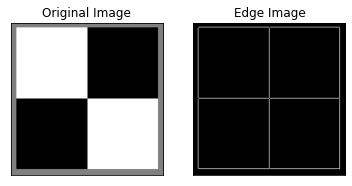

In [8]:
import numpy as np
from matplotlib import pyplot as plt
edges = cv2.Canny(img,100,200)
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

### 2. Detecção de Linhas

Implemente um método de transformação de Hough para localizar linhas. Observe que o sistema de coordenadas usado tem sua origem no canto superior esquerdo da imagem e com o eixo $y$ apontando para baixo. Assim, o pixel correspondente às coordenadas $(x, y)$ deve votar em parâmetros de linha $(\rho, \theta)$ onde  $\rho = x \cos(\theta) + y \sin(\theta)$ e $\theta = \arctan{x/y}$.

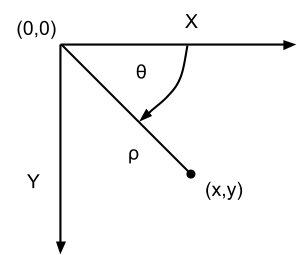

Isso tem o efeito de tornar a direção angular positiva no sentido horário em vez de no sentido anti-horário na convenção usual.

**A -** Escreva uma função `hough_lines_acc()` que calcula a transformação de Hough para linhas e produz um acumulador H, que representa o espaço paramétrico $(\rho, \theta)$ discretizado com a resolução radial e angular desejada.
 <img src="https://www.learnopencv.com/wp-content/uploads/2019/03/hough-transform-accumulator-1024x1024.png" width="300"/>

Qualquer compartimento (*bin*) nessa matriz 2D corresponde a uma linha e damos o nome acumulador porque usaremos os compartimentos desse array para coletar evidências sobre quais linhas existem na imagem. 

A função deve receber dois parâmetros além da imagem binária de bordas:
 1. `rho` - resolução radial $\rho$ do acumulador em pixels;
 2. `theta` - resolução angular $\theta$ do acumulador em radianos;

A função deve retornar três objetos:
 1. O *grid* acumulador de hough H em que cada posição representa o número de votos da linha com parâmetros $(\rho, \theta)$;
 2. Os vetor de valores $\theta$ que correspondem às colunas do *grid* H;
 3. Os vetor de valores $\rho$ que correspondem às linhas do *grid* H.

In [ ]:
## INSIRA AQUI O CÓDIGO

**B -** Aplique a função `hough_lines_acc()` na imagem da Parte I e exiba o acumulador de hough H.

In [ ]:
## INSIRA AQUI O CÓDIGO

**C -** Escreva uma função `hough_peaks()` que encontre os índices do *grid* acumulador (aqui, parâmetros de linha) que correspondem aos máximos locais e tenham um número mínimo de votos especificado. Observe que você precisa retornar uma matriz com formato `(número_de_linhas_encontradas, 2)` em que os $\rho$s estão na coluna 0 os $\theta$s na coluna 1. 

In [ ]:
## INSIRA AQUI O CÓDIGO

**D -** Escreva uma função `hough_lines_draw()` para desenhar linhas coloridas que correspondam aos picos encontrados na matriz do acumulador. Isso significa que você precisa pesquisar os valores $\rho$, $\theta$ usando os índices de pico e, em seguida, convertê-los (de volta) para parâmetros de linha em coordenadas cartesianas.

In [ ]:
## INSIRA AQUI O CÓDIGO

**E -** Que parâmetros você usou para encontrar linhas nesta imagem?

`## ESCREVA AQUI A RESPOSTA

### 3 - Detecção de linhas em imagem com ruído

Use agora a imagem `ps1-input0-noise.png` - a mesma imagem de antes, mas agora com ruído.

<img src="images/ps1-input0-noise.png" width="300"/>

**A -** Calcule uma versão moderadamente suavizada desta imagem usando um filtro Gaussiano e use $\sigma$ do filtro com pelo menos alguns pixels de tamanho.

In [ ]:
## INSIRA AQUI O CÓDIGO
## EXIBA A IMAGEM SUAVIZADA

**B -** Usando um operador de borda de sua escolha, crie uma imagem de borda binária para a imagem original (`ps1-input0-noise.png`) e a versão suavizada acima.

In [111]:
## INSIRA AQUI O CÓDIGO
## EXIBA AS IMAGENS DE BORDA

**C -** Agora aplique seu método de Hough à versão suavizada da imagem da borda. Seu objetivo é ajustar os algoritmos de filtragem, localização de bordas e Hough para encontrar as linhas da melhor maneira possível neste caso de teste.

In [ ]:
## INSIRA AQUI O CÓDIGO
## EXIBA COMO IMAGEM O ACUMULADOR DE HOUGH
## EXIBA A IMAGEM RUIDOSA ORIGINAL COM AS LINHAS DESENHADAS

O que você precisou fazer para obter seus melhores resultados?

### 4 - Detecção de linhas em imagem real

A imagem `ps1-input1.png` contém objetos cujos limites são círculos (moedas) ou linhas (canetas).

<img src="images/ps1-input1.png" width="300"/>

In [ ]:
 Para esta pergunta, você ainda encontra linhas.

**A -** Gere uma versão monocromática da imagem (você pode escolher um único canal de cor ou usar uma função de conversão de cor para escala de cinza integrada) e compute uma versão moderadamente suavizada dessa imagem usando um filtro Gaussiano. Novamente, escolha o $\sigma$ do filtro com pelo menos alguns pixels de tamanho.

In [115]:
## INSIRA AQUI O CÓDIGO
## EXIBA A IMAGEM SUAVIZADA

**B -** Crie uma imagem de borda para a versão suavizada da imagema acima

In [116]:
## INSIRA AQUI O CÓDIGO
## EXIBA A IMAGEM DE BORDA

**C -** Aplique seu algoritmo de Hough à imagem de borda para encontrar linhas ao longo das canetas e desenhe as linhas coloridas na imagem monocromática original (não na imagem de borda), não se preocupe com as linhas desenhadas se estendendo até o limite da imagem.

In [117]:
## INSIRA AQUI O CÓDIGO
## EXIBA COMO IMAGEM O ACUMULADOR DE HOUGH
## EXIBA A IMAGEM ORIGINAL COM AS LINHAS DESENHADAS